In [9]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import optuna
from sklearn.metrics import mean_squared_error,roc_curve,auc,confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize,LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


In [10]:
df=pd.read_csv("NYC_Cleaned_Optimized.csv")

In [11]:
df.columns

Index(['Complaint_ID', 'Precinct', 'Offense_Code', 'Offense_Description',
       'Precinct_Code', 'Precinct_Description', 'Crime_Status',
       'Offense_Level', 'Borough', 'Location_Type', 'Premises_Type',
       'Jurisdiction', 'JURISDICTION_CODE', 'Suspect_Age', 'Suspect_Race',
       'Suspect_Gender', 'Lat', 'Lon', 'Patrol_Borough', 'Victim_Age',
       'Victim_Race', 'Victim_Gender', 'in_psa', 'in_psa_housing',
       'in_transport', 'in_park', 'Start_Datetime', 'End_Datetime',
       'Duration_Hours', 'Is_Multi_Day', 'Year', 'Month', 'Day', 'DayOfWeek',
       'Hour', 'Is_Weekend'],
      dtype='object')

In [12]:
list_input_output=['Lat','Lon','in_psa_housing','in_transport','in_park','Year','Month','Day','Hour','DayOfWeek','Victim_Age','Victim_Race','Victim_Gender','Is_Weekend','Borough','Offense_Description']
df_final = df[list_input_output]

In [13]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6919629 entries, 0 to 6919628
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Lat                  float64
 1   Lon                  float64
 2   in_psa_housing       bool   
 3   in_transport         bool   
 4   in_park              bool   
 5   Year                 int64  
 6   Month                int64  
 7   Day                  int64  
 8   Hour                 int64  
 9   DayOfWeek            int64  
 10  Victim_Age           object 
 11  Victim_Race          object 
 12  Victim_Gender        object 
 13  Is_Weekend           bool   
 14  Borough              object 
 15  Offense_Description  object 
dtypes: bool(4), float64(2), int64(5), object(5)
memory usage: 659.9+ MB


In [14]:
df_final = df_final[df_final['Offense_Description'] != 'OTHER']

In [15]:
df_final['Victim_Gender'] = df_final['Victim_Gender'].replace({'D': 'U', 'E': 'U'})

In [16]:
df_final['Victim_Race'] = df_final['Victim_Race'].replace({'OTHER': 'UNKNOWN'})

In [17]:
df_final['Offense_Description'].value_counts()

Offense_Description
PROPERTY_RELATED          3354741
PERSONAL_RELATED          1169402
SEXUAL_RELATED             979383
ADMINISTRATIVE_RELATED     678085
DRUGS/ALCOHOL_RELATED      509370
Name: count, dtype: int64

In [18]:
df['Borough'].value_counts()

Borough
BROOKLYN         2059224
MANHATTAN        1661381
BRONX            1500663
QUEENS           1368756
STATEN ISLAND     324618
UNKNOWN             4987
Name: count, dtype: int64

In [19]:
categorical_cols = ['Victim_Age', 'Victim_Race', 'Victim_Gender', 'Borough', 'Offense_Description']

label_mappings = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_final[col] = le.fit_transform(df_final[col])  # Encode the column
    mapping = {class_name: i for i, class_name in enumerate(le.classes_)}  # Create the dictionary manually
    label_mappings[col] = mapping  # Store mapping for the variable

for col, mapping in label_mappings.items():
    print(f"Mapping for {col}: {mapping}")

Mapping for Victim_Age: {'18-24': 0, '25-44': 1, '45-64': 2, '65+': 3, '<18': 4, 'UNKNOWN': 5}
Mapping for Victim_Race: {'AMERICAN INDIAN/ALASKAN NATIVE': 0, 'ASIAN / PACIFIC ISLANDER': 1, 'BLACK': 2, 'BLACK HISPANIC': 3, 'UNKNOWN': 4, 'WHITE': 5, 'WHITE HISPANIC': 6}
Mapping for Victim_Gender: {'F': 0, 'M': 1, 'U': 2}
Mapping for Borough: {'BRONX': 0, 'BROOKLYN': 1, 'MANHATTAN': 2, 'QUEENS': 3, 'STATEN ISLAND': 4, 'UNKNOWN': 5}
Mapping for Offense_Description: {'ADMINISTRATIVE_RELATED': 0, 'DRUGS/ALCOHOL_RELATED': 1, 'PERSONAL_RELATED': 2, 'PROPERTY_RELATED': 3, 'SEXUAL_RELATED': 4}


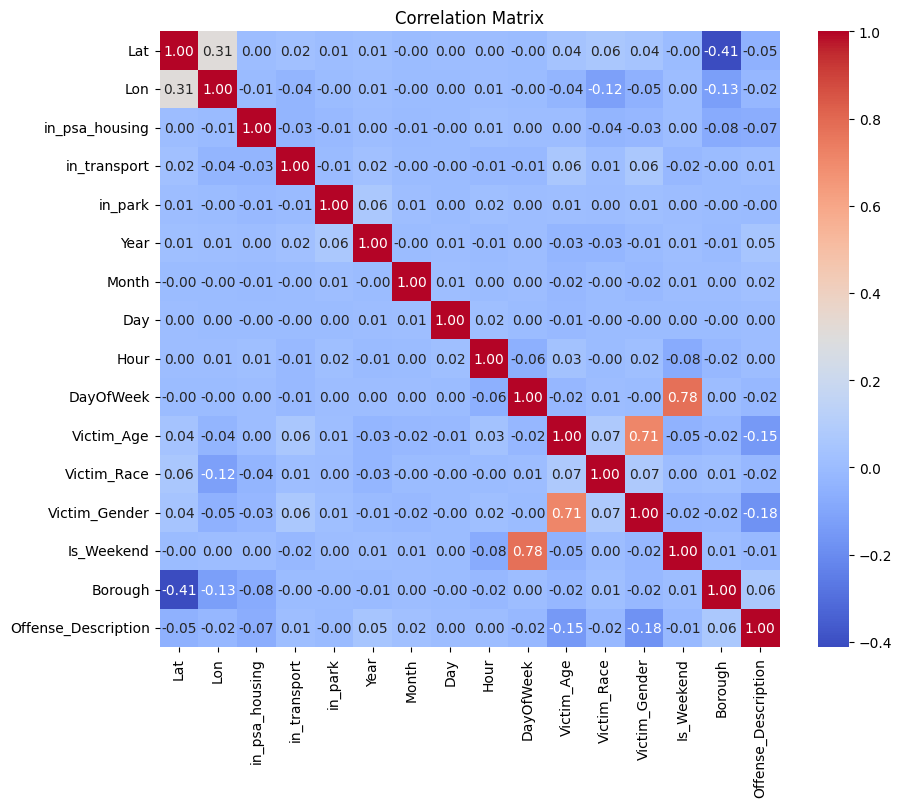

In [20]:
corr_matrix = df_final.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

In [44]:
df_final

,Lat,Lon,in_psa_housing,in_transport,in_park,Year,Month,Day,Hour,DayOfWeek,Victim_Age,Victim_Race,Victim_Gender,Is_Weekend,Borough,Offense_Description
0,40.845868,-73.915888,False,False,False,2015,5,28,15,3,1,6,0,False,0,4
1,40.627061,-74.077149,False,False,False,2013,10,28,13,0,2,5,1,False,4,3
2,40.800966,-73.969047,False,False,False,2012,5,9,20,2,5,4,2,False,2,2
3,40.745242,-73.894253,False,False,False,2014,1,3,13,4,2,1,1,False,3,3
4,40.810352,-73.924942,False,False,False,2016,4,13,0,2,5,4,2,False,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6919624,40.741889,-73.859886,False,False,False,2018,9,11,22,1,5,4,2,False,3,3
6919625,40.878054,-73.863244,False,False,False,2018,1,15,14,0,2,2,0,False,0,3
6919626,40.672202,-73.983786,False,False,True,2018,8,7,14,1,0,2,1,False,1,2
6919627,40.785050,-73.856852,False,False,False,2018,12,2,4,6,1,1,0,True,3,2


In [45]:
bool_cols = ['in_psa_housing', 'in_transport', 'in_park', 'Is_Weekend']

df_final[bool_cols] = df_final[bool_cols].astype(int)

In [46]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6690981 entries, 0 to 6919628
Data columns (total 16 columns):
 #   Column               Dtype  
---  ------               -----  
 0   Lat                  float64
 1   Lon                  float64
 2   in_psa_housing       int32  
 3   in_transport         int32  
 4   in_park              int32  
 5   Year                 int64  
 6   Month                int64  
 7   Day                  int64  
 8   Hour                 int64  
 9   DayOfWeek            int64  
 10  Victim_Age           int32  
 11  Victim_Race          int32  
 12  Victim_Gender        int32  
 13  Is_Weekend           int32  
 14  Borough              int32  
 15  Offense_Description  int32  
dtypes: float64(2), int32(9), int64(5)
memory usage: 638.1 MB


In [47]:
X = df_final.drop('Offense_Description', axis=1)
y = df_final['Offense_Description']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)


print("Class distribution before undersampling (training):", Counter(y_train))
print("Class distribution after undersampling (training):", Counter(y_train_resampled))
print("Class distribution (testing):", Counter(y_test))

Class distribution before undersampling (training): Counter({3: 2349670, 2: 818642, 4: 684906, 0: 474028, 1: 356440})
Class distribution after undersampling (training): Counter({0: 356440, 1: 356440, 2: 356440, 3: 356440, 4: 356440})
Class distribution (testing): Counter({3: 1005071, 2: 350760, 4: 294477, 0: 204057, 1: 152930})


## First Model XGBOOST

In [17]:
def xgboost_objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': 5,  
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'tree_method': "hist",
        'device': "cuda",
        'verbosity': 1,
        'n_jobs': -1,  
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 2000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10)
    }

    model = XGBClassifier(**params)
    
    model.fit(X_train_resampled, y_train_resampled)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [ ]:
study_xgboost = optuna.create_study(direction='minimize')  
study_xgboost.optimize(xgboost_objective, n_trials=15, n_jobs=4)

print("=" * 50)
print("Best Trial Summary")
print("=" * 50)
print(f"Best Value (MSE): {study_xgboost.best_trial.value:.3f}")
print("\nBest Hyperparameters:")
for key, value in study_xgboost.best_trial.params.items():
    print(f"  {key}: {value}")
print("\nOptimization Completed")

[I 2024-12-27 17:32:34,600] A new study created in memory with name: no-name-17679894-b193-41a8-aa89-c6e2ba0cef97


In [48]:
best_params = {
    'max_depth': 6,
    'learning_rate': 0.03427459793722965,
    'n_estimators': 1806,
    'subsample': 0.2827842796362878,
    'colsample_bytree': 0.4405543923338674,
    'min_child_weight': 5.4633360643409485,
    'objective': 'multi:softmax',
    'num_class': 5,  
    'eval_metric': 'mlogloss',
    'booster': 'gbtree',
    'tree_method': 'hist',  
    'verbosity': 1,
    'n_jobs': -1  
}

xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train_resampled, y_train_resampled)


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4405543923338674, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03427459793722965,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5.4633360643409485, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1806,
              n_jobs=-1, num_class=5, num_parallel_tree=None, ...)

In [49]:
y_pred = xgb_model.predict(X_test)

Classification Report

In [50]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.19      0.20    204057
           1       0.37      0.93      0.53    152930
           2       0.34      0.40      0.37    350760
           3       0.75      0.38      0.50   1005071
           4       0.30      0.52      0.38    294477

    accuracy                           0.43   2007295
   macro avg       0.39      0.48      0.40   2007295
weighted avg       0.53      0.43      0.43   2007295



Confusion Matrix

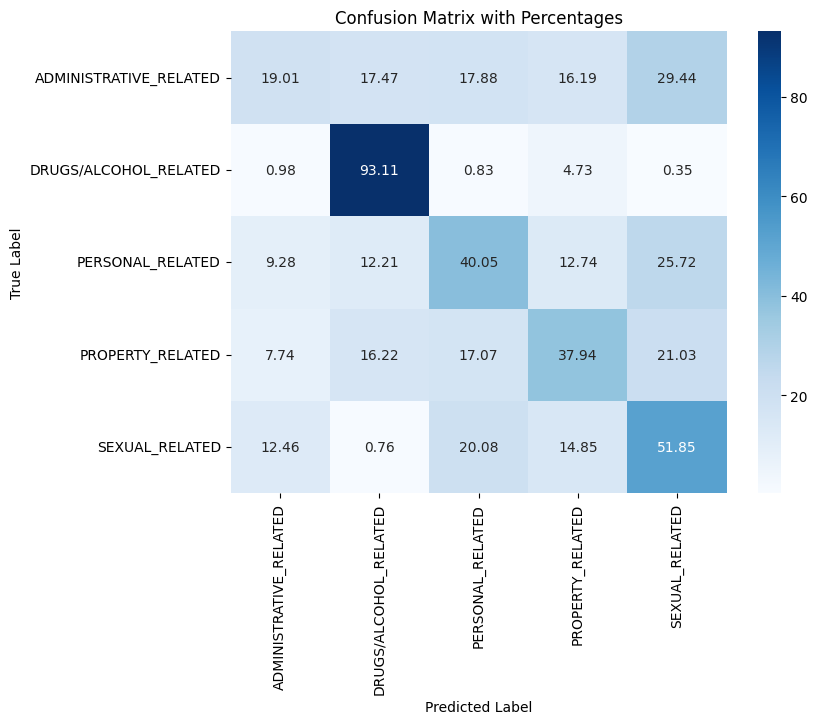

In [51]:
label_mapping = {
    'ADMINISTRATIVE_RELATED': 0,
    'DRUGS/ALCOHOL_RELATED': 1,
    'PERSONAL_RELATED': 2,
    'PROPERTY_RELATED': 3,
    'SEXUAL_RELATED': 4
}

index_to_label = {v: k for k, v in label_mapping.items()}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[index_to_label[i] for i in range(len(index_to_label))],  
    yticklabels=[index_to_label[i] for i in range(len(index_to_label))]   
)
plt.title("Confusion Matrix with Percentages")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


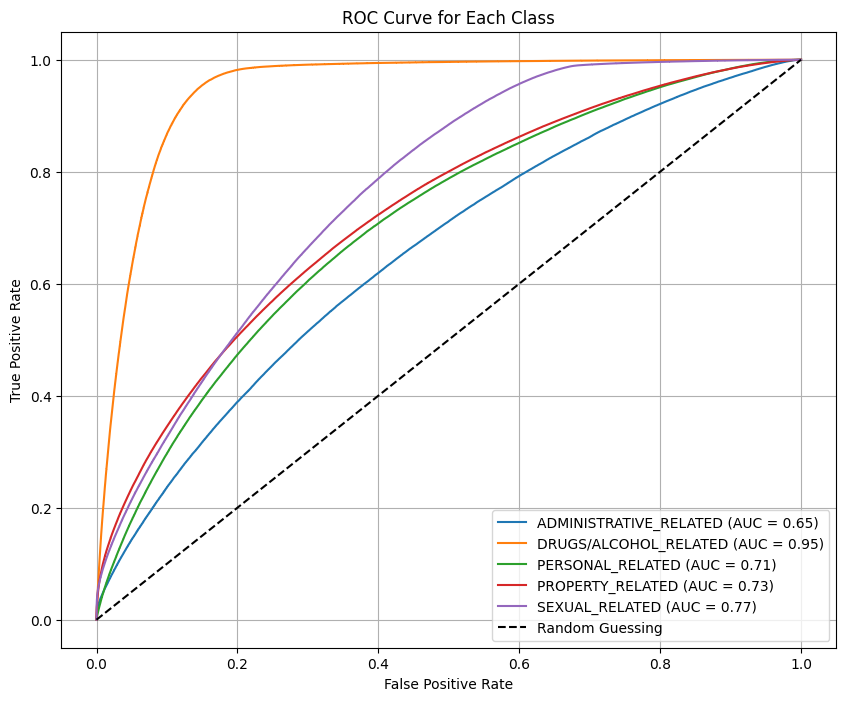

In [52]:
y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

y_pred_proba = xgb_model.predict_proba(X_test)

label_mapping = {
    'ADMINISTRATIVE_RELATED': 0,
    'DRUGS/ALCOHOL_RELATED': 1,
    'PERSONAL_RELATED': 2,
    'PROPERTY_RELATED': 3,
    'SEXUAL_RELATED': 4
}

index_to_label = {v: k for k, v in label_mapping.items()}

plt.figure(figsize=(10, 8))
for i in range(len(index_to_label)):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{index_to_label[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.title("ROC Curve for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

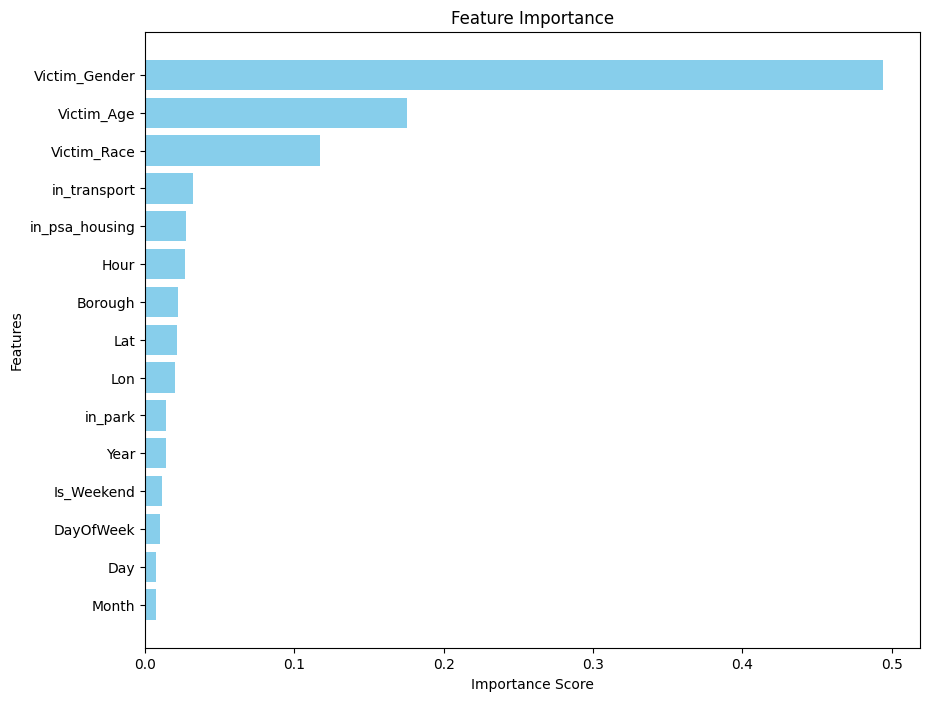

In [53]:
feature_importance = xgb_model.feature_importances_

features = X_train.columns  
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.gca().invert_yaxis()  
plt.show()


In [54]:
with open('xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

## Second Model LGBM

In [ ]:
def lgbm_objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 5,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15)
    }

    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse

In [ ]:
study_lgbm = optuna.create_study(direction='minimize')  
study_lgbm.optimize(lgbm_objective, n_trials=20, n_jobs=4)

print("=" * 50)
print("Best Trial Summary")
print("=" * 50)
print(f"Best Value (MSE): {study_lgbm.best_trial.value:.3f}")
print("\nBest Hyperparameters:")
for key, value in study_lgbm.best_trial.params.items():
    print(f"  {key}: {value}")
print("\nOptimization Completed")

In [55]:
best_params = {
    'objective': 'multiclass',
    'num_class': 5,
    'boosting_type': 'gbdt',
    'num_leaves': 145,
    'learning_rate': 0.04564719979219796,
    'feature_fraction': 0.7810653247764673,
    'bagging_fraction': 0.38984474500052535,
    'bagging_freq': 7,
    'min_child_samples': 25,
    'lambda_l1': 0.7045460728083552,
    'lambda_l2': 6.865242529571035,
    'max_depth': 12
}
lgbm_model = LGBMClassifier(**best_params)
lgbm_model.fit(X_train_resampled, y_train_resampled)

[LightGBM] [Warning] feature_fraction is set=0.7810653247764673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810653247764673
[LightGBM] [Warning] lambda_l1 is set=0.7045460728083552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7045460728083552
[LightGBM] [Warning] lambda_l2 is set=6.865242529571035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.865242529571035
[LightGBM] [Warning] bagging_fraction is set=0.38984474500052535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38984474500052535
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7810653247764673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810653247764673
[LightGBM] [Warning] lambda_l1 is set=0.7045460728083552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7045460728083552
[LightGBM] [Warning] lambda_l2 is set

LGBMClassifier(bagging_fraction=0.38984474500052535, bagging_freq=7,
               feature_fraction=0.7810653247764673,
               lambda_l1=0.7045460728083552, lambda_l2=6.865242529571035,
               learning_rate=0.04564719979219796, max_depth=12,
               min_child_samples=25, num_class=5, num_leaves=145,
               objective='multiclass')

In [56]:
y_pred = lgbm_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.7810653247764673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810653247764673
[LightGBM] [Warning] lambda_l1 is set=0.7045460728083552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7045460728083552
[LightGBM] [Warning] lambda_l2 is set=6.865242529571035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.865242529571035
[LightGBM] [Warning] bagging_fraction is set=0.38984474500052535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38984474500052535
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


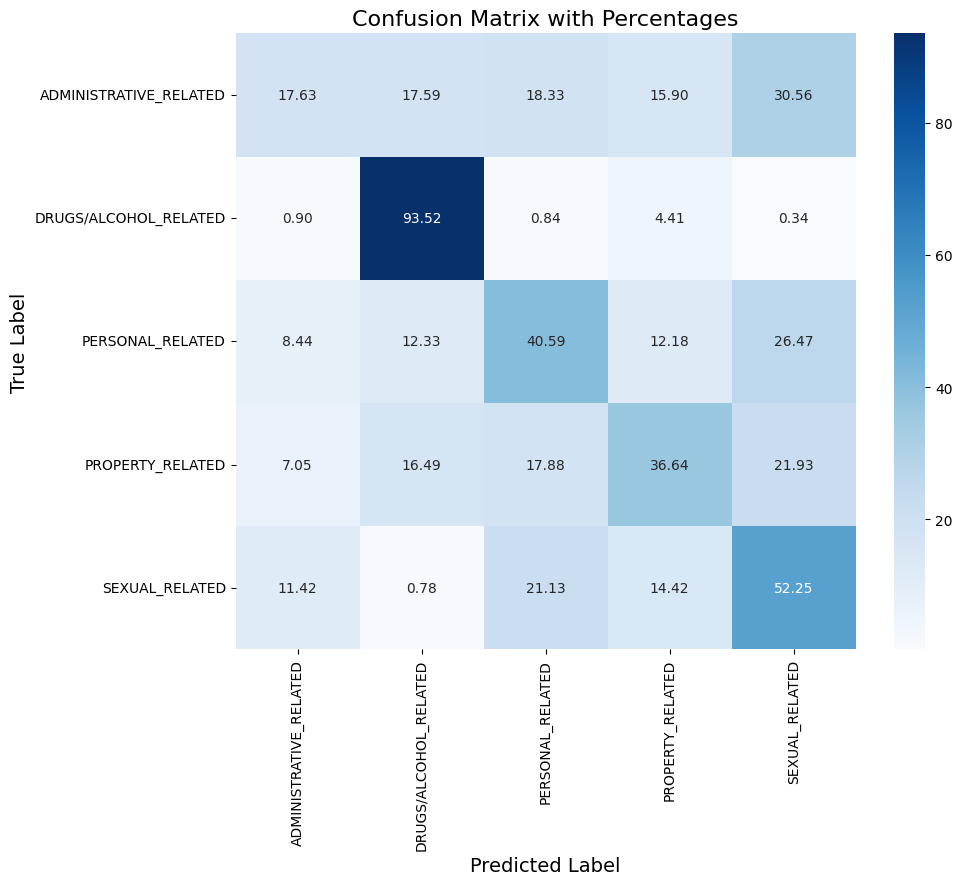

In [57]:
label_mapping = {
    'ADMINISTRATIVE_RELATED': 0,
    'DRUGS/ALCOHOL_RELATED': 1,
    'PERSONAL_RELATED': 2,
    'PROPERTY_RELATED': 3,
    'SEXUAL_RELATED': 4
}
index_to_label = {v: k for k, v in label_mapping.items()}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[index_to_label[i] for i in range(len(index_to_label))],  # Custom labels for x-axis
    yticklabels=[index_to_label[i] for i in range(len(index_to_label))]   # Custom labels for y-axis
)
plt.title("Confusion Matrix with Percentages", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

In [58]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.18      0.19    204057
           1       0.37      0.94      0.53    152930
           2       0.34      0.41      0.37    350760
           3       0.75      0.37      0.49   1005071
           4       0.29      0.52      0.37    294477

    accuracy                           0.42   2007295
   macro avg       0.39      0.48      0.39   2007295
weighted avg       0.52      0.42      0.42   2007295



[LightGBM] [Warning] feature_fraction is set=0.7810653247764673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7810653247764673
[LightGBM] [Warning] lambda_l1 is set=0.7045460728083552, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7045460728083552
[LightGBM] [Warning] lambda_l2 is set=6.865242529571035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.865242529571035
[LightGBM] [Warning] bagging_fraction is set=0.38984474500052535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.38984474500052535
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


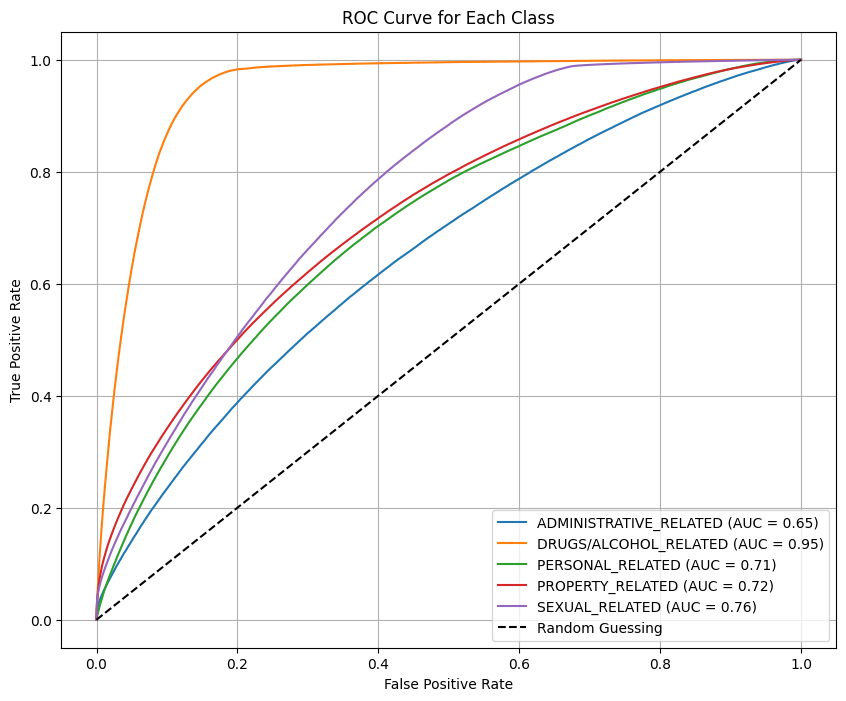

In [59]:
y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

y_pred_proba = lgbm_model.predict_proba(X_test)

label_mapping = {
    'ADMINISTRATIVE_RELATED': 0,
    'DRUGS/ALCOHOL_RELATED': 1,
    'PERSONAL_RELATED': 2,
    'PROPERTY_RELATED': 3,
    'SEXUAL_RELATED': 4
}

index_to_label = {v: k for k, v in label_mapping.items()}

plt.figure(figsize=(10, 8))
for i in range(len(index_to_label)):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{index_to_label[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.title("ROC Curve for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [60]:
with open('lgbm_model.pkl', 'wb') as f:
    pickle.dump(lgbm_model, f)

## Third model Catboost

In [33]:
def objective_catboost(trial):

    params = {
        'iterations': trial.suggest_int('iterations', 50, 2000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.1, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'loss_function': 'MultiClass',
        'verbose': 0        
    }

    model = CatBoostClassifier(**params)
    model.fit(
        X_train_resampled,
        y_train_resampled,
        eval_set=(X_test, y_test),
        verbose_eval=False  
    )

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    return mse


In [ ]:
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=10, n_jobs=1)

print("=" * 50)
print("Best Trial Summary")
print("=" * 50)
print(f"Best Value (F1 Macro): {study_catboost.best_trial.value:.3f}")
print("\nBest Hyperparameters:")
for key, value in study_catboost.best_trial.params.items():
    print(f"  {key}: {value}")
print("\nOptimization Completed")

In [61]:
catboost_params = {
    'iterations': 800,
    'depth': 7,
    'learning_rate': 0.17543128769746083,
    'l2_leaf_reg': 2.4733952666572274,
    'border_count': 251,
    'colsample_bylevel': 0.8753217976948955,
    'min_data_in_leaf': 2,  
    'loss_function': 'MultiClass',
    'verbose': 100
}

In [62]:
catboost_model = CatBoostClassifier(**catboost_params)
catboost_model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test), use_best_model=True, verbose=100)

0:	learn: 1.5093805	test: 1.5502466	best: 1.5502466 (0)	total: 387ms	remaining: 5m 9s
100:	learn: 1.2063667	test: 1.3169822	best: 1.3169822 (100)	total: 33.2s	remaining: 3m 49s
200:	learn: 1.1933010	test: 1.3033883	best: 1.3033883 (200)	total: 1m 6s	remaining: 3m 17s
300:	learn: 1.1856156	test: 1.2966310	best: 1.2966310 (300)	total: 1m 38s	remaining: 2m 43s
400:	learn: 1.1794829	test: 1.2915720	best: 1.2915720 (400)	total: 2m 12s	remaining: 2m 11s
500:	learn: 1.1743040	test: 1.2879142	best: 1.2879142 (500)	total: 2m 45s	remaining: 1m 38s
600:	learn: 1.1699304	test: 1.2849982	best: 1.2849982 (600)	total: 3m 19s	remaining: 1m 6s
700:	learn: 1.1661629	test: 1.2830124	best: 1.2830107 (699)	total: 4m 10s	remaining: 35.4s
799:	learn: 1.1626350	test: 1.2814147	best: 1.2814147 (799)	total: 4m 42s	remaining: 0us

bestTest = 1.281414714
bestIteration = 799



In [63]:
y_pred = catboost_model.predict(X_test)

In [64]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['ADMINISTRATIVE_RELATED', 'DRUGS/ALCOHOL_RELATED', 'PERSONAL_RELATED', 'PROPERTY_RELATED', 'SEXUAL_RELATED']))


Classification Report:
                        precision    recall  f1-score   support

ADMINISTRATIVE_RELATED       0.21      0.20      0.20    204057
 DRUGS/ALCOHOL_RELATED       0.38      0.93      0.54    152930
      PERSONAL_RELATED       0.34      0.41      0.37    350760
      PROPERTY_RELATED       0.75      0.38      0.51   1005071
        SEXUAL_RELATED       0.30      0.51      0.38    294477

              accuracy                           0.43   2007295
             macro avg       0.40      0.49      0.40   2007295
          weighted avg       0.53      0.43      0.44   2007295



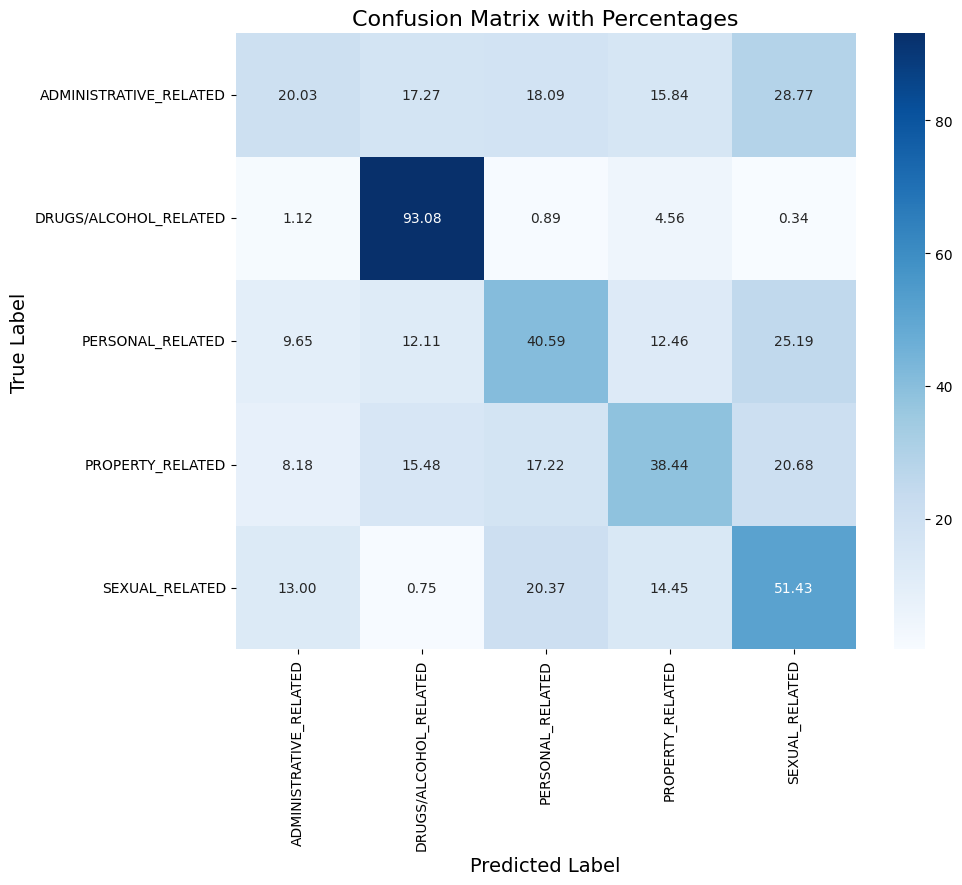

In [65]:
abel_mapping = {
    'ADMINISTRATIVE_RELATED': 0,
    'DRUGS/ALCOHOL_RELATED': 1,
    'PERSONAL_RELATED': 2,
    'PROPERTY_RELATED': 3,
    'SEXUAL_RELATED': 4
}
index_to_label = {v: k for k, v in label_mapping.items()}
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix_percentage,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[index_to_label[i] for i in range(len(index_to_label))],
    yticklabels=[index_to_label[i] for i in range(len(index_to_label))]
)
plt.title("Confusion Matrix with Percentages", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.show()

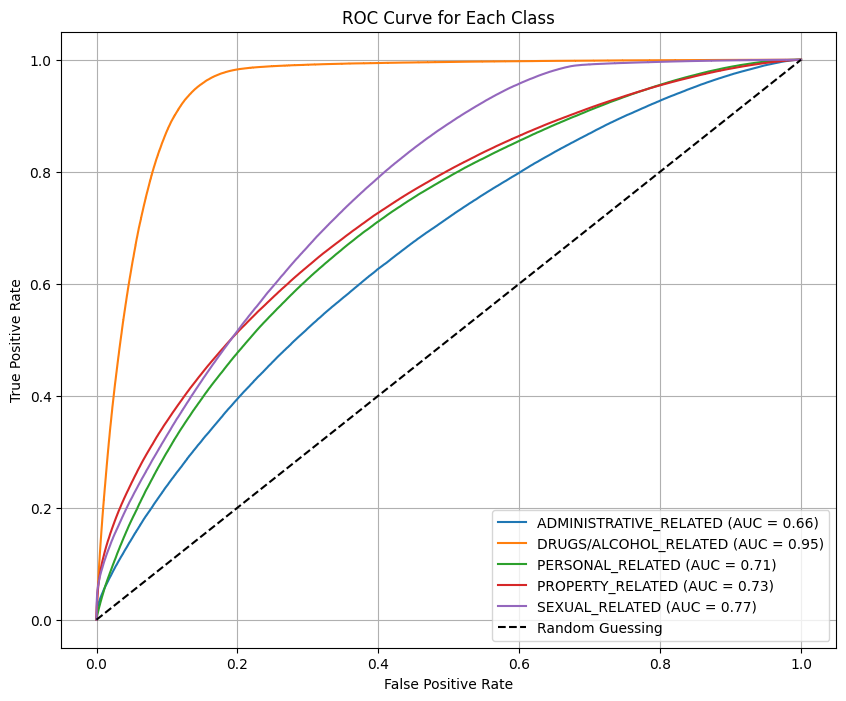

In [66]:
y_test_one_hot = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

y_pred_proba = catboost_model.predict_proba(X_test)

label_mapping = {
    'ADMINISTRATIVE_RELATED': 0,
    'DRUGS/ALCOHOL_RELATED': 1,
    'PERSONAL_RELATED': 2,
    'PROPERTY_RELATED': 3,
    'SEXUAL_RELATED': 4
}

index_to_label = {v: k for k, v in label_mapping.items()}

plt.figure(figsize=(10, 8))
for i in range(len(index_to_label)):
    fpr, tpr, _ = roc_curve(y_test_one_hot[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{index_to_label[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.title("ROC Curve for Each Class")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [67]:
with open('catboost_model.pkl', 'wb') as f:
    pickle.dump(catboost_model, f)